In [1]:
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)

import time
import numpy as np
import scipy
from scipy import ndimage
import sklearn
from sklearn import preprocessing
from sklearn import metrics

from keras.layers import Dense, Input
from keras.models import Model
from keras import optimizers
from keras.models import load_model

from PIL import Image

import tensorflow as tf
from keras import backend as K
sess = tf.Session()
K.set_session(sess)


Using TensorFlow backend.


In [2]:
def resize(im,percent):
    """ retaille suivant un pourcentage 'percent' """
    w,h = im.size
    return im.resize(((percent*w)/100,(percent*h)/100))

def resize2(im,pixels):
    """ retaille le cotÃ© le plus long en 'pixels'
        (pour tenir dans une frame de pixels x pixels)
    """
    (wx,wy) = im.size
    rx=1.0*wx/pixels
    ry=1.0*wy/pixels
    if rx>ry:
        rr=rx
    else:
        rr=ry
    return im.resize((int(wx/rr), int(wy/rr)))
 


In [3]:
img = Image.open("lena512.jpg") # image extension *.png,*.jpg
new_width  = 32
new_height = 32
compressed = img.resize((new_width, new_height), Image.ANTIALIAS)
compressed.save("lena32.jpg") # format may what u want ,*.png,*jpg,*.gif
 

In [4]:
compressed = img.resize((16, 16), Image.ANTIALIAS)
compressed.save("lena16.jpg")

# Opening compressed, enlarging and saving enlarged for NN input
input_image_source = Image.open("lena16.jpg")
new_width  = 32
new_height = 32
enlarged = input_image_source.resize((new_width, new_height), Image.ANTIALIAS)
enlarged.show()
enlarged.save("lena32_enlarged.jpg")


![lena512](lena512.jpg)
![lena32](lena32.jpg)
![lena16](lena16.jpg)



In [5]:
# everything up til here is from pastebin
# normalize (use sklearn instead of vanilla numpy)

# Raw enlarged image used for NN input
input_image = ndimage.imread("lena32_enlarged.jpg").astype(float)
input_image = input_image.reshape((32*32,1))
min_max_scaler = preprocessing.MinMaxScaler()
input_image = min_max_scaler.fit_transform(input_image)
#print(input_image)
#print(np.average(input_image))
#print(np.std(input_image))
#print(np.min(input_image))
#print(np.max(input_image))
#print(scipy.stats.describe(input_image))

# Raw image original used for NN output
output_image = ndimage.imread("lena32.jpg").astype(float)
output_image = output_image.reshape((32*32,1))
output_image = min_max_scaler.fit_transform(output_image)

input_rows, input_cols = input_image.shape

#print(output_image)
#print(np.average(output_image))
#print(np.std(output_image))
#print(np.min(output_image))
#print(np.max(output_image))
#print(scipy.stats.describe(output_image))


In [6]:
# function to instantiate neural network
# see https://keras.io/getting-started/sequential-model-guide/
import keras
from keras.models import Sequential
from keras.layers import Input, Embedding, LSTM, Dense, Dropout, concatenate
from keras.regularizers import l1

def create_model(num_components=input_cols, 
                 num_hidden_layers=1,
                 hidden_layer_size=30, 
                 dropout=(1.0/3.0), 
                 reg_penalty=0.0000, 
                 activation='relu'):

    # create model
    model = Sequential()
    # 1st hidden layer of specified size hidden_layer_size, L1 regularization, activation
    # 1st layer needs input_dim
    model.add(Dense(hidden_layer_size, 
                    input_dim=num_components, 
                    kernel_initializer='TruncatedNormal', 
                    kernel_regularizer=l1(reg_penalty),
                    activation=activation
                   ))
    
    # dropout layer
    if dropout > 0:
        model.add(Dropout(dropout))
        
    # if num_hidden_layers > 1, add additional layers
    # input_dim is implicit from output of prev layer
    for _ in range(num_hidden_layers - 1):
        model.add(Dense(hidden_layer_size, 
                    kernel_initializer='TruncatedNormal', 
                    kernel_regularizer=l1(reg_penalty),
                    activation=activation
                   ))
        if dropout > 0:
            model.add(Dropout(dropout))
        
    # send outputs of final hidden layer to sigmoid layer for output between 0 and 1
    model.add(Dense(1, 
                    activation='sigmoid',
                    kernel_initializer='TruncatedNormal', 
                    kernel_regularizer=l1(reg_penalty)
                   ))
    
    model.compile(loss='mean_absolute_error', 
                  optimizer='adam', 
                  metrics=['mean_absolute_error','mean_squared_error'])
    print(model.summary())
    
    return model


In [7]:
model = create_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                60        
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 91.0
Trainable params: 91.0
Non-trainable params: 0.0
_________________________________________________________________
None


In [8]:
fit = model.fit(input_image,
                output_image,
                epochs=1000, 
                batch_size=1024,
                verbose=1)    


Epoch 1/1000
1024/1024 [==============================] - 0s - loss: 0.1947 - mean_absolute_error: 0.1947 - mean_squared_error: 0.0549
Epoch 2/1000
1024/1024 [==============================] - 0s - loss: 0.1946 - mean_absolute_error: 0.1946 - mean_squared_error: 0.0549
Epoch 3/1000
1024/1024 [==============================] - 0s - loss: 0.1945 - mean_absolute_error: 0.1945 - mean_squared_error: 0.0548
Epoch 4/1000
1024/1024 [==============================] - 0s - loss: 0.1944 - mean_absolute_error: 0.1944 - mean_squared_error: 0.0547
Epoch 5/1000
1024/1024 [==============================] - 0s - loss: 0.1942 - mean_absolute_error: 0.1942 - mean_squared_error: 0.0546
Epoch 6/1000
1024/1024 [==============================] - 0s - loss: 0.1942 - mean_absolute_error: 0.1942 - mean_squared_error: 0.0546
Epoch 7/1000
1024/1024 [==============================] - 0s - loss: 0.1941 - mean_absolute_error: 0.1941 - mean_squared_error: 0.0546
Epoch 8/1000
1024/1024 [==============================]

1024/1024 [==============================] - 0s - loss: 0.1859 - mean_absolute_error: 0.1859 - mean_squared_error: 0.0501
Epoch 62/1000
1024/1024 [==============================] - 0s - loss: 0.1855 - mean_absolute_error: 0.1855 - mean_squared_error: 0.0499
Epoch 63/1000
1024/1024 [==============================] - 0s - loss: 0.1856 - mean_absolute_error: 0.1856 - mean_squared_error: 0.0499
Epoch 64/1000
1024/1024 [==============================] - 0s - loss: 0.1852 - mean_absolute_error: 0.1852 - mean_squared_error: 0.0497
Epoch 65/1000
1024/1024 [==============================] - 0s - loss: 0.1852 - mean_absolute_error: 0.1852 - mean_squared_error: 0.0497
Epoch 66/1000
1024/1024 [==============================] - 0s - loss: 0.1846 - mean_absolute_error: 0.1846 - mean_squared_error: 0.0495
Epoch 67/1000
1024/1024 [==============================] - 0s - loss: 0.1845 - mean_absolute_error: 0.1845 - mean_squared_error: 0.0493
Epoch 68/1000
1024/1024 [==============================] - 0s 

1024/1024 [==============================] - 0s - loss: 0.1705 - mean_absolute_error: 0.1705 - mean_squared_error: 0.0424
Epoch 122/1000
1024/1024 [==============================] - 0s - loss: 0.1700 - mean_absolute_error: 0.1700 - mean_squared_error: 0.0421
Epoch 123/1000
1024/1024 [==============================] - 0s - loss: 0.1701 - mean_absolute_error: 0.1701 - mean_squared_error: 0.0422
Epoch 124/1000
1024/1024 [==============================] - 0s - loss: 0.1700 - mean_absolute_error: 0.1700 - mean_squared_error: 0.0422
Epoch 125/1000
1024/1024 [==============================] - 0s - loss: 0.1698 - mean_absolute_error: 0.1698 - mean_squared_error: 0.0419
Epoch 126/1000
1024/1024 [==============================] - 0s - loss: 0.1692 - mean_absolute_error: 0.1692 - mean_squared_error: 0.0418
Epoch 127/1000
1024/1024 [==============================] - 0s - loss: 0.1699 - mean_absolute_error: 0.1699 - mean_squared_error: 0.0419
Epoch 128/1000
1024/1024 [==============================

1024/1024 [==============================] - 0s - loss: 0.1526 - mean_absolute_error: 0.1526 - mean_squared_error: 0.0346
Epoch 181/1000
1024/1024 [==============================] - 0s - loss: 0.1527 - mean_absolute_error: 0.1527 - mean_squared_error: 0.0344
Epoch 182/1000
1024/1024 [==============================] - 0s - loss: 0.1524 - mean_absolute_error: 0.1524 - mean_squared_error: 0.0342
Epoch 183/1000
1024/1024 [==============================] - 0s - loss: 0.1525 - mean_absolute_error: 0.1525 - mean_squared_error: 0.0343
Epoch 184/1000
1024/1024 [==============================] - 0s - loss: 0.1524 - mean_absolute_error: 0.1524 - mean_squared_error: 0.0344
Epoch 185/1000
1024/1024 [==============================] - 0s - loss: 0.1506 - mean_absolute_error: 0.1506 - mean_squared_error: 0.0335
Epoch 186/1000
1024/1024 [==============================] - 0s - loss: 0.1507 - mean_absolute_error: 0.1507 - mean_squared_error: 0.0335
Epoch 187/1000
1024/1024 [==============================

1024/1024 [==============================] - 0s - loss: 0.1340 - mean_absolute_error: 0.1340 - mean_squared_error: 0.0274
Epoch 240/1000
1024/1024 [==============================] - 0s - loss: 0.1317 - mean_absolute_error: 0.1317 - mean_squared_error: 0.0266
Epoch 241/1000
1024/1024 [==============================] - 0s - loss: 0.1325 - mean_absolute_error: 0.1325 - mean_squared_error: 0.0267
Epoch 242/1000
1024/1024 [==============================] - 0s - loss: 0.1307 - mean_absolute_error: 0.1307 - mean_squared_error: 0.0263
Epoch 243/1000
1024/1024 [==============================] - 0s - loss: 0.1316 - mean_absolute_error: 0.1316 - mean_squared_error: 0.0261
Epoch 244/1000
1024/1024 [==============================] - 0s - loss: 0.1316 - mean_absolute_error: 0.1316 - mean_squared_error: 0.0260
Epoch 245/1000
1024/1024 [==============================] - 0s - loss: 0.1310 - mean_absolute_error: 0.1310 - mean_squared_error: 0.0262
Epoch 246/1000
1024/1024 [==============================

1024/1024 [==============================] - 0s - loss: 0.1165 - mean_absolute_error: 0.1165 - mean_squared_error: 0.0213
Epoch 299/1000
1024/1024 [==============================] - 0s - loss: 0.1149 - mean_absolute_error: 0.1149 - mean_squared_error: 0.0209
Epoch 300/1000
1024/1024 [==============================] - 0s - loss: 0.1156 - mean_absolute_error: 0.1156 - mean_squared_error: 0.0211
Epoch 301/1000
1024/1024 [==============================] - 0s - loss: 0.1164 - mean_absolute_error: 0.1164 - mean_squared_error: 0.0213
Epoch 302/1000
1024/1024 [==============================] - 0s - loss: 0.1144 - mean_absolute_error: 0.1144 - mean_squared_error: 0.0211
Epoch 303/1000
1024/1024 [==============================] - 0s - loss: 0.1153 - mean_absolute_error: 0.1153 - mean_squared_error: 0.0209
Epoch 304/1000
1024/1024 [==============================] - 0s - loss: 0.1149 - mean_absolute_error: 0.1149 - mean_squared_error: 0.0207
Epoch 305/1000
1024/1024 [==============================

1024/1024 [==============================] - 0s - loss: 0.1063 - mean_absolute_error: 0.1063 - mean_squared_error: 0.0183
Epoch 358/1000
1024/1024 [==============================] - 0s - loss: 0.1057 - mean_absolute_error: 0.1057 - mean_squared_error: 0.0181
Epoch 359/1000
1024/1024 [==============================] - 0s - loss: 0.1040 - mean_absolute_error: 0.1040 - mean_squared_error: 0.0174
Epoch 360/1000
1024/1024 [==============================] - 0s - loss: 0.1050 - mean_absolute_error: 0.1050 - mean_squared_error: 0.0179
Epoch 361/1000
1024/1024 [==============================] - 0s - loss: 0.1024 - mean_absolute_error: 0.1024 - mean_squared_error: 0.0171
Epoch 362/1000
1024/1024 [==============================] - 0s - loss: 0.1049 - mean_absolute_error: 0.1049 - mean_squared_error: 0.0177
Epoch 363/1000
1024/1024 [==============================] - 0s - loss: 0.1031 - mean_absolute_error: 0.1031 - mean_squared_error: 0.0176
Epoch 364/1000
1024/1024 [==============================

1024/1024 [==============================] - 0s - loss: 0.0978 - mean_absolute_error: 0.0978 - mean_squared_error: 0.0158
Epoch 417/1000
1024/1024 [==============================] - 0s - loss: 0.0960 - mean_absolute_error: 0.0960 - mean_squared_error: 0.0152
Epoch 418/1000
1024/1024 [==============================] - 0s - loss: 0.0954 - mean_absolute_error: 0.0954 - mean_squared_error: 0.0151
Epoch 419/1000
1024/1024 [==============================] - 0s - loss: 0.0965 - mean_absolute_error: 0.0965 - mean_squared_error: 0.0154
Epoch 420/1000
1024/1024 [==============================] - 0s - loss: 0.0970 - mean_absolute_error: 0.0970 - mean_squared_error: 0.0154
Epoch 421/1000
1024/1024 [==============================] - 0s - loss: 0.0980 - mean_absolute_error: 0.0980 - mean_squared_error: 0.0160
Epoch 422/1000
1024/1024 [==============================] - 0s - loss: 0.0976 - mean_absolute_error: 0.0976 - mean_squared_error: 0.0158
Epoch 423/1000
1024/1024 [==============================

1024/1024 [==============================] - 0s - loss: 0.0948 - mean_absolute_error: 0.0948 - mean_squared_error: 0.0148
Epoch 476/1000
1024/1024 [==============================] - 0s - loss: 0.0965 - mean_absolute_error: 0.0965 - mean_squared_error: 0.0158
Epoch 477/1000
1024/1024 [==============================] - 0s - loss: 0.0950 - mean_absolute_error: 0.0950 - mean_squared_error: 0.0150
Epoch 478/1000
1024/1024 [==============================] - 0s - loss: 0.0948 - mean_absolute_error: 0.0948 - mean_squared_error: 0.0152
Epoch 479/1000
1024/1024 [==============================] - 0s - loss: 0.0939 - mean_absolute_error: 0.0939 - mean_squared_error: 0.0146
Epoch 480/1000
1024/1024 [==============================] - 0s - loss: 0.0938 - mean_absolute_error: 0.0938 - mean_squared_error: 0.0147
Epoch 481/1000
1024/1024 [==============================] - 0s - loss: 0.0971 - mean_absolute_error: 0.0971 - mean_squared_error: 0.0157
Epoch 482/1000
1024/1024 [==============================

1024/1024 [==============================] - 0s - loss: 0.0933 - mean_absolute_error: 0.0933 - mean_squared_error: 0.0148
Epoch 535/1000
1024/1024 [==============================] - 0s - loss: 0.0958 - mean_absolute_error: 0.0958 - mean_squared_error: 0.0152
Epoch 536/1000
1024/1024 [==============================] - 0s - loss: 0.0923 - mean_absolute_error: 0.0923 - mean_squared_error: 0.0142
Epoch 537/1000
1024/1024 [==============================] - 0s - loss: 0.0935 - mean_absolute_error: 0.0935 - mean_squared_error: 0.0143
Epoch 538/1000
1024/1024 [==============================] - 0s - loss: 0.0924 - mean_absolute_error: 0.0924 - mean_squared_error: 0.0140
Epoch 539/1000
1024/1024 [==============================] - 0s - loss: 0.0926 - mean_absolute_error: 0.0926 - mean_squared_error: 0.0143
Epoch 540/1000
1024/1024 [==============================] - 0s - loss: 0.0945 - mean_absolute_error: 0.0945 - mean_squared_error: 0.0147
Epoch 541/1000
1024/1024 [==============================

1024/1024 [==============================] - 0s - loss: 0.0935 - mean_absolute_error: 0.0935 - mean_squared_error: 0.0146
Epoch 594/1000
1024/1024 [==============================] - 0s - loss: 0.0910 - mean_absolute_error: 0.0910 - mean_squared_error: 0.0138
Epoch 595/1000
1024/1024 [==============================] - 0s - loss: 0.0937 - mean_absolute_error: 0.0937 - mean_squared_error: 0.0141
Epoch 596/1000
1024/1024 [==============================] - 0s - loss: 0.0922 - mean_absolute_error: 0.0922 - mean_squared_error: 0.0141
Epoch 597/1000
1024/1024 [==============================] - 0s - loss: 0.0922 - mean_absolute_error: 0.0922 - mean_squared_error: 0.0140
Epoch 598/1000
1024/1024 [==============================] - 0s - loss: 0.0905 - mean_absolute_error: 0.0905 - mean_squared_error: 0.0137
Epoch 599/1000
1024/1024 [==============================] - 0s - loss: 0.0922 - mean_absolute_error: 0.0922 - mean_squared_error: 0.0144
Epoch 600/1000
1024/1024 [==============================

1024/1024 [==============================] - 0s - loss: 0.0923 - mean_absolute_error: 0.0923 - mean_squared_error: 0.0142
Epoch 653/1000
1024/1024 [==============================] - 0s - loss: 0.0939 - mean_absolute_error: 0.0939 - mean_squared_error: 0.0148
Epoch 654/1000
1024/1024 [==============================] - 0s - loss: 0.0904 - mean_absolute_error: 0.0904 - mean_squared_error: 0.0137
Epoch 655/1000
1024/1024 [==============================] - 0s - loss: 0.0905 - mean_absolute_error: 0.0905 - mean_squared_error: 0.0141
Epoch 656/1000
1024/1024 [==============================] - 0s - loss: 0.0920 - mean_absolute_error: 0.0920 - mean_squared_error: 0.0142
Epoch 657/1000
1024/1024 [==============================] - 0s - loss: 0.0907 - mean_absolute_error: 0.0907 - mean_squared_error: 0.0140
Epoch 658/1000
1024/1024 [==============================] - 0s - loss: 0.0906 - mean_absolute_error: 0.0906 - mean_squared_error: 0.0135
Epoch 659/1000
1024/1024 [==============================

1024/1024 [==============================] - 0s - loss: 0.0903 - mean_absolute_error: 0.0903 - mean_squared_error: 0.0137
Epoch 712/1000
1024/1024 [==============================] - 0s - loss: 0.0909 - mean_absolute_error: 0.0909 - mean_squared_error: 0.0138
Epoch 713/1000
1024/1024 [==============================] - 0s - loss: 0.0896 - mean_absolute_error: 0.0896 - mean_squared_error: 0.0137
Epoch 714/1000
1024/1024 [==============================] - 0s - loss: 0.0897 - mean_absolute_error: 0.0897 - mean_squared_error: 0.0136
Epoch 715/1000
1024/1024 [==============================] - 0s - loss: 0.0903 - mean_absolute_error: 0.0903 - mean_squared_error: 0.0137
Epoch 716/1000
1024/1024 [==============================] - 0s - loss: 0.0898 - mean_absolute_error: 0.0898 - mean_squared_error: 0.0135
Epoch 717/1000
1024/1024 [==============================] - 0s - loss: 0.0910 - mean_absolute_error: 0.0910 - mean_squared_error: 0.0138
Epoch 718/1000
1024/1024 [==============================

1024/1024 [==============================] - 0s - loss: 0.0905 - mean_absolute_error: 0.0905 - mean_squared_error: 0.0136
Epoch 771/1000
1024/1024 [==============================] - 0s - loss: 0.0884 - mean_absolute_error: 0.0884 - mean_squared_error: 0.0134
Epoch 772/1000
1024/1024 [==============================] - 0s - loss: 0.0889 - mean_absolute_error: 0.0889 - mean_squared_error: 0.0133
Epoch 773/1000
1024/1024 [==============================] - 0s - loss: 0.0896 - mean_absolute_error: 0.0896 - mean_squared_error: 0.0135
Epoch 774/1000
1024/1024 [==============================] - 0s - loss: 0.0903 - mean_absolute_error: 0.0903 - mean_squared_error: 0.0137
Epoch 775/1000
1024/1024 [==============================] - 0s - loss: 0.0905 - mean_absolute_error: 0.0905 - mean_squared_error: 0.0140
Epoch 776/1000
1024/1024 [==============================] - 0s - loss: 0.0900 - mean_absolute_error: 0.0900 - mean_squared_error: 0.0138
Epoch 777/1000
1024/1024 [==============================

1024/1024 [==============================] - 0s - loss: 0.0904 - mean_absolute_error: 0.0904 - mean_squared_error: 0.0138
Epoch 830/1000
1024/1024 [==============================] - 0s - loss: 0.0899 - mean_absolute_error: 0.0899 - mean_squared_error: 0.0140
Epoch 831/1000
1024/1024 [==============================] - 0s - loss: 0.0884 - mean_absolute_error: 0.0884 - mean_squared_error: 0.0133
Epoch 832/1000
1024/1024 [==============================] - 0s - loss: 0.0896 - mean_absolute_error: 0.0896 - mean_squared_error: 0.0136
Epoch 833/1000
1024/1024 [==============================] - 0s - loss: 0.0917 - mean_absolute_error: 0.0917 - mean_squared_error: 0.0140
Epoch 834/1000
1024/1024 [==============================] - 0s - loss: 0.0900 - mean_absolute_error: 0.0900 - mean_squared_error: 0.0138
Epoch 835/1000
1024/1024 [==============================] - 0s - loss: 0.0886 - mean_absolute_error: 0.0886 - mean_squared_error: 0.0134
Epoch 836/1000
1024/1024 [==============================

1024/1024 [==============================] - 0s - loss: 0.0862 - mean_absolute_error: 0.0862 - mean_squared_error: 0.0129
Epoch 889/1000
1024/1024 [==============================] - 0s - loss: 0.0908 - mean_absolute_error: 0.0908 - mean_squared_error: 0.0139
Epoch 890/1000
1024/1024 [==============================] - 0s - loss: 0.0899 - mean_absolute_error: 0.0899 - mean_squared_error: 0.0140
Epoch 891/1000
1024/1024 [==============================] - 0s - loss: 0.0909 - mean_absolute_error: 0.0909 - mean_squared_error: 0.0139
Epoch 892/1000
1024/1024 [==============================] - 0s - loss: 0.0898 - mean_absolute_error: 0.0898 - mean_squared_error: 0.0135
Epoch 893/1000
1024/1024 [==============================] - 0s - loss: 0.0900 - mean_absolute_error: 0.0900 - mean_squared_error: 0.0140
Epoch 894/1000
1024/1024 [==============================] - 0s - loss: 0.0886 - mean_absolute_error: 0.0886 - mean_squared_error: 0.0134
Epoch 895/1000
1024/1024 [==============================

1024/1024 [==============================] - 0s - loss: 0.0902 - mean_absolute_error: 0.0902 - mean_squared_error: 0.0136
Epoch 948/1000
1024/1024 [==============================] - 0s - loss: 0.0879 - mean_absolute_error: 0.0879 - mean_squared_error: 0.0132
Epoch 949/1000
1024/1024 [==============================] - 0s - loss: 0.0885 - mean_absolute_error: 0.0885 - mean_squared_error: 0.0135
Epoch 950/1000
1024/1024 [==============================] - 0s - loss: 0.0882 - mean_absolute_error: 0.0882 - mean_squared_error: 0.0133
Epoch 951/1000
1024/1024 [==============================] - 0s - loss: 0.0894 - mean_absolute_error: 0.0894 - mean_squared_error: 0.0134
Epoch 952/1000
1024/1024 [==============================] - 0s - loss: 0.0890 - mean_absolute_error: 0.0890 - mean_squared_error: 0.0133
Epoch 953/1000
1024/1024 [==============================] - 0s - loss: 0.0891 - mean_absolute_error: 0.0891 - mean_squared_error: 0.0133
Epoch 954/1000
1024/1024 [==============================

In [9]:
# predict output from input model that was used to train model
train_image = model.predict(input_image)
train_image

array([[ 0.61702144],
       [ 0.59742957],
       [ 0.57752174],
       ..., 
       [ 0.19193909],
       [ 0.17183457],
       [ 0.19545883]], dtype=float32)

In [10]:
# check mean absolute error - I don't know why this doesn't match last batch above
metrics.mean_absolute_error(output_image, train_image)

0.080826037034270701

In [11]:
np.sum(np.absolute(train_image - output_image))/input_rows

0.080826037034270701

In [12]:
# run calc with Keras loss function to test it
# why is this different from mean absolute error show above? ¯\_(ツ)_/¯

mae_tensor = keras.losses.mean_absolute_error(output_image.transpose(), train_image.transpose())
sess.run(mae_tensor)

array([ 0.08082604])

In [13]:
train_image - output_image

array([[ 0.10801243],
       [ 0.05238453],
       [-0.0621179 ],
       ..., 
       [-0.08734019],
       [-0.09393119],
       [ 0.10086423]])

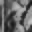

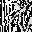

In [14]:
# show the image
train_image = train_image.reshape((32,32))
import PIL.Image
from cStringIO import StringIO
import IPython.display

def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

    
showarray(255 * train_image.reshape((32,32)))

diff = train_image - output_image.reshape((32,32))
showarray(255 * diff)

In [15]:
output_image.shape

(1024, 1)

In [14]:
hidden_layers_list= [1,2,3]
hidden_layer_size_list=[4,8,16,32]
dropout_list=[0, 0.333, 0.5]
reg_penalty_list = [0, 0.001]
activation_list = ['relu']

epochs = 1
max_epochs = 10000
max_unimproved = 30
batch_size = input_rows

image_list = []
error_list = []
hyperparam_list = []

count=0
for hidden_layers in hidden_layers_list:
    for hidden_layer_size in hidden_layer_size_list:
        for dropout in dropout_list:
            for reg_penalty in reg_penalty_list:
                for activation in activation_list:
                    
                    create_model(num_components=input_cols, 
                                 num_hidden_layers=hidden_layers,
                                 hidden_layer_size=hidden_layer_size, 
                                 dropout=dropout, 
                                 reg_penalty=reg_penalty, 
                                 activation=activation)

                    # train until no improvement in loss 
                    best_loss = 999999
                    best_epoch = 0
                    last_epoch = 0
                    for i in range(max_epochs // epochs):
                        fit = model.fit(input_image,
                                        output_image,
                                        epochs=epochs, 
                                        batch_size=input_rows,
                                        verbose=0
                                       )  
                        #get best loss, break if not improved for max_unimproved epochs
                        train_loss_index = np.argmin(fit.history['loss'])
                        train_loss = fit.history['loss'][train_loss_index]
                        if train_loss < best_loss:
                            best_loss = train_loss
                            best_epoch = i * epochs + train_loss_index
                            print("%s Best loss now %f after %d epochs" % (time.strftime("%H:%M:%S"), best_loss, best_epoch))
                            # save best model so far
                            modelname = "model_%d_%d_%.4f_%.6f_%s.h5" % (hidden_layers, 
                                                                         hidden_layer_size, 
                                                                         dropout, 
                                                                         reg_penalty, 
                                                                         activation)
                            model.save(modelname)  # creates a HDF5 file 'modelname.h5'
                        else:
                            epochs_unimproved = (i + 1) * epochs - best_epoch
                            if epochs_unimproved > max_unimproved:
                                break
                            #else:
                            #    print("%s Best loss still %f after %d epochs" % (time.strftime("%H:%M:%S"), best_loss, epochs_unimproved))

                    # go back to best saved model, load from h5
                    model = load_model(modelname)
                    train_image = model.predict(input_image)
                    image_list.append(train_image)
                    error_list.append(metrics.mean_absolute_error(output_image, train_image))
                    hyperparam_list.append((hidden_layers, hidden_layer_size, dropout, reg_penalty, activation))
                    print("%s model %d MAE %f" % (time.strftime("%H:%M:%S"),
                                                  count, metrics.mean_absolute_error(output_image, train_image)))
                    count += 1
                    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4)                 8         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 13.0
Trainable params: 13
Non-trainable params: 0.0
_________________________________________________________________
None
00:49:42 Best loss now 0.090461 after 0 epochs
00:49:42 Best loss now 0.088891 after 1 epochs
00:49:42 Best loss now 0.087224 after 20 epochs
00:49:42 Best loss now 0.087024 after 45 epochs
00:49:43 model 0 MAE 0.080561
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 4)                 8         
_________________________________________________________________
dense_6 (Dense)              (None, 1)           

00:49:55 Best loss now 0.091746 after 0 epochs
00:49:55 Best loss now 0.086962 after 1 epochs
00:49:55 Best loss now 0.086074 after 4 epochs
00:49:56 model 9 MAE 0.079709
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 8)                 16        
_________________________________________________________________
dropout_8 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 9         
Total params: 25.0
Trainable params: 25.0
Non-trainable params: 0.0
_________________________________________________________________
None
00:49:57 Best loss now 0.090366 after 0 epochs
00:49:57 Best loss now 0.088224 after 1 epochs
00:49:57 Best loss now 0.086126 after 9 epochs
00:49:59 model 10 MAE 0.079644
________________________________________________________

00:50:16 Best loss now 0.089075 after 0 epochs
00:50:16 Best loss now 0.087775 after 1 epochs
00:50:16 Best loss now 0.085244 after 3 epochs
00:50:18 model 18 MAE 0.078791
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 33        
Total params: 97.0
Trainable params: 97
Non-trainable params: 0.0
_________________________________________________________________
None
00:50:19 Best loss now 0.088483 after 0 epochs
00:50:19 Best loss now 0.088342 after 2 epochs
00:50:19 Best loss now 0.087872 after 4 epochs
00:50:19 Best loss now 0.085607 after 7 epochs
00:50:21 model 19 MAE 0.078842
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (

00:50:45 model 26 MAE 0.078290
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 4)                 8         
_________________________________________________________________
dropout_20 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_61 (Dense)             (None, 4)                 20        
_________________________________________________________________
dropout_21 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 5         
Total params: 33.0
Trainable params: 33.0
Non-trainable params: 0.0
_________________________________________________________________
None
00:50:45 Best loss now 0.086207 after 0 epochs
00:50:45 Best loss now 0.085416 after 7 epochs
00:50:46 B

00:51:14 Best loss now 0.088930 after 0 epochs
00:51:14 Best loss now 0.087515 after 1 epochs
00:51:14 Best loss now 0.085586 after 3 epochs
00:51:14 Best loss now 0.085571 after 12 epochs
00:51:14 Best loss now 0.085123 after 37 epochs
00:51:14 Best loss now 0.084999 after 38 epochs
00:51:15 Best loss now 0.083843 after 57 epochs
00:51:18 model 34 MAE 0.077413
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 8)                 16        
_________________________________________________________________
dropout_32 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_85 (Dense)             (None, 8)                 72        
_________________________________________________________________
dropout_33 (Dropout)         (None, 8)                 0         
__________________________________________

00:51:48 Best loss now 0.088173 after 0 epochs
00:51:49 Best loss now 0.086356 after 1 epochs
00:51:49 Best loss now 0.084981 after 20 epochs
00:51:49 Best loss now 0.084883 after 21 epochs
00:51:49 Best loss now 0.083858 after 40 epochs
00:51:52 model 41 MAE 0.077126
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_105 (Dense)            (None, 32)                64        
_________________________________________________________________
dense_106 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_107 (Dense)            (None, 1)                 33        
Total params: 1,153.0
Trainable params: 1,153
Non-trainable params: 0.0
_________________________________________________________________
None
00:51:53 Best loss now 0.089640 after 0 epochs
00:51:54 Best loss now 0.085924 after 1 epochs
00:51:54 Best loss now 0.085733 

00:52:33 model 48 MAE 0.076911
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_127 (Dense)            (None, 4)                 8         
_________________________________________________________________
dense_128 (Dense)            (None, 4)                 20        
_________________________________________________________________
dense_129 (Dense)            (None, 4)                 20        
_________________________________________________________________
dense_130 (Dense)            (None, 1)                 5         
Total params: 53.0
Trainable params: 53
Non-trainable params: 0.0
_________________________________________________________________
None
00:52:34 Best loss now 0.087952 after 0 epochs
00:52:34 Best loss now 0.086314 after 1 epochs
00:52:34 Best loss now 0.085826 after 4 epochs
00:52:34 Best loss now 0.085756 after 6 epochs
00:52:34 Best loss now 0.083935 after 9 epochs
00:

00:53:11 model 54 MAE 0.076819
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_151 (Dense)            (None, 8)                 16        
_________________________________________________________________
dense_152 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_153 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_154 (Dense)            (None, 1)                 9         
Total params: 169.0
Trainable params: 169
Non-trainable params: 0.0
_________________________________________________________________
None
00:53:13 Best loss now 0.085350 after 0 epochs
00:53:13 Best loss now 0.084197 after 3 epochs
00:53:18 model 55 MAE 0.076783
_________________________________________________________________
Layer (type)                 Output Shape    

00:53:57 Best loss now 0.087581 after 0 epochs
00:53:58 Best loss now 0.085481 after 1 epochs
00:53:58 Best loss now 0.084327 after 3 epochs
00:54:03 model 61 MAE 0.076689
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_179 (Dense)            (None, 16)                32        
_________________________________________________________________
dropout_74 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_180 (Dense)            (None, 16)                272       
_________________________________________________________________
dropout_75 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_181 (Dense)            (None, 16)                272       
_________________________________________________________________
dropout_76 (Dropout)         (None, 

00:54:45 Best loss now 0.086824 after 0 epochs
00:54:46 Best loss now 0.086676 after 3 epochs
00:54:46 Best loss now 0.084624 after 6 epochs
00:54:46 Best loss now 0.083549 after 7 epochs
00:54:52 model 67 MAE 0.076693
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_203 (Dense)            (None, 32)                64        
_________________________________________________________________
dropout_86 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_204 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_87 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_205 (Dense)            (None, 32)                1056      
_______________________________________________________

Lowest MAE 0.076624 at index 71
Loading model (hidden_layers 3, hidden_layer_size 32, dropout 0.500000, reg_penalty 0.001000, activation relu)
0.0766239536105


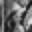

In [15]:
# load best model with smallest MAE
best_index = np.argmin(error_list)
best_error = error_list[best_index]
best_image = image_list[best_index]
hidden_layers, hidden_layer_size, dropout, reg_penalty, activation = hyperparam_list[best_index]
print("Lowest MAE %f at index %d" % (best_error, best_index))

# load model
print ("Loading model (hidden_layers %d, hidden_layer_size %d, dropout %f, reg_penalty %f, activation %s)" % (hidden_layers, 
                                             hidden_layer_size, 
                                             dropout, 
                                             reg_penalty, 
                                             activation))

loadmodelname = "model_%d_%d_%.4f_%.6f_%s.h5" % (hidden_layers, 
                                             hidden_layer_size, 
                                             dropout, 
                                             reg_penalty, 
                                             activation)

loadmodel = load_model(loadmodelname)

#check MAE and show image
train_image = loadmodel.predict(input_image)
print(metrics.mean_absolute_error(output_image, train_image))

showarray(255 * train_image.reshape((32,32)))


In [ ]:
# show images
for hyperparams, image in zip(hyperparam_list, image_list):
    hidden_layers, hidden_layer_size, dropout, reg_penalty, activation = hyperparams
    print (hidden_layers, hidden_layer_size, dropout, reg_penalty, activation)
    showarray(255 * image.reshape((32,32)))
    
    # can also show diff vs. output_image or prev_image to visualize changes
    #if prev_image is None:
    #    prev_image = image
    #diff = image - prev_image
    #showarray(255 * diff.reshape((32,32)))
    #prev_image = image
    
    # or diff vs. output_image
    #diff = image - output_image
    #showarray(255 * diff.reshape((32,32)))
    

                    


In [ ]:
# for amusement we can try building some autoencoders
# https://blog.keras.io/building-autoencoders-in-keras.html

from keras.models import Model
encoding_dim = 32  # 784 floats -> 32 floats -> compression factor 24.5:1
input_img = Input(shape=(784,))
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
# (the model we're going to train end-to-end)
autoencoder = Model(input_img, decoded)

# this model maps an input to its intermediate representation 
# (extract model from 1st 2 layers, which compresses)
encoder = Model(input_img, encoded)

# this model maps the compressed version to the uncompressed version
# (extract model from last layer, which uncompresses)
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

#
#TODO
#add a function to create the model with variable compression, number of layers, regularization


In [ ]:
# train the model on MNIST
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print x_train.shape
print x_test.shape

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))


In [ ]:
# show some test images

encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
